In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
def plot_image(image,cmap="gray"):
    plt.imshow(image,cmap=cmap, interpolation="nearest")
    plt.axis("off")

def plot_n_image(n_rows, n_cols, X, y, cmap="binary"):
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(X[index], cmap=cmap, interpolation="nearest")
            plt.axis('off')
            plt.title(class_names[y[index]], fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

In [102]:
from keras.utils.np_utils import to_categorical
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
# X_train_full = X_train_full / 255.
# X_test = X_test / 255.
# X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
# y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# X_train = X_train[..., np.newaxis]
# X_valid = X_valid[..., np.newaxis]
# X_test = X_test[..., np.newaxis]

X_train = X_train_full / 255.0
X_test = X_test / 255.0
X_train = X_train.ravel().reshape(-1,28,28,1)
X_test = X_test.ravel().reshape(-1,28,28,1)
y_train = to_categorical(y_train_full, num_classes = 10)

In [98]:
X_train.shape

(55000, 28, 28, 1)

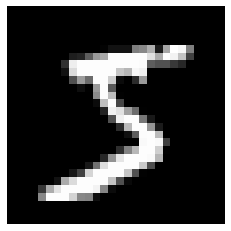

In [95]:
plot_image(X_train[0].reshape(28,28))

In [81]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [82]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [103]:
from sklearn.model_selection import train_test_split
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model= keras.models.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, kernel_size = 3, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Conv2D(128, kernel_size = 4, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [108]:
# early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("cnn_mnist.h5",save_best_only=True)
annealer = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
epochs = 45
# onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)

X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, y_train, test_size = 0.1)
history = model.fit_generator(datagen.flow(X_train2,Y_train2,
                                                 batch_size=64),epochs = epochs, 
                                    steps_per_epoch = X_train2.shape[0]//64, validation_data = (X_val2,Y_val2), 
                                    callbacks=[model_checkpoint_cb,annealer], verbose=0)



  ...
    to  
  ['...']


KeyboardInterrupt: 

In [107]:
model.evaluate(X_test, to_categorical(y_test,num_classes = 10))

10000/10000 [==============================] - 2s 229us/sample - loss: 0.0124 - accuracy: 0.9957


[0.01239194478705922, 0.9957]

In [64]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 20s 368us/sample - loss: 0.1886 - accuracy: 0.9424 - val_loss: 0.0460 - val_accuracy: 0.9886
Epoch 2/10
55000/55000 [==============================] - 20s 360us/sample - loss: 0.0810 - accuracy: 0.9755 - val_loss: 0.0452 - val_accuracy: 0.9892
Epoch 3/10
55000/55000 [==============================] - 20s 356us/sample - loss: 0.0602 - accuracy: 0.9815 - val_loss: 0.0386 - val_accuracy: 0.9888
Epoch 4/10
55000/55000 [==============================] - 19s 353us/sample - loss: 0.0493 - accuracy: 0.9845 - val_loss: 0.0339 - val_accuracy: 0.9914
Epoch 5/10
55000/55000 [==============================] - 19s 354us/sample - loss: 0.0400 - accuracy: 0.9873 - val_loss: 0.0405 - val_accuracy: 0.9888
Epoch 6/10
55000/55000 [==============================] - 20s 357us/sample - loss: 0.0363 - accuracy: 0.9885 - val_loss: 0.0330 - val_accuracy: 0.9922
Epoch 7/10
55000/55000 [=====================

[0.02864573866481992, 0.9926]